## Masked noise attenuation

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            seismic_plot, spectrum_plot)

from unet import u_net, conv_block

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:19]))
train_set = Dataset(tindex, SeismicBatch)
len(train_set)

65664

In [4]:
config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_raw = tf.placeholder('float', shape=(None, 3000, 1), name='trace_in')
    targets = tf.placeholder('float', shape=(None, 3000, 1), name='target')
    alpha = tf.placeholder('float', name='alpha')
    beta = tf.placeholder('float', name='beta')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    #Attention branch
    with tf.variable_scope("attention_scope"):
        out_attention = u_net(trace_raw, depth=3, filters=8, kernel_size=3,
                              activation='elu', is_training=is_training)
        out_attention = conv_block(out_attention, 'ca', filters=1, kernel_size=3,
                                   activation='sigmoid')
        print('attention', out_attention.get_shape())

    attention_sum = tf.reduce_sum(out_attention, axis=1, keepdims=True)
    print('attention_sum', attention_sum.get_shape())

    #Define a domain for sigmoid function
    sigm_x = tf.fill(tf.shape(out_attention), 0.0)
    arange = tf.range(0, tf.cast(tf.shape(sigm_x)[1], 'float'), dtype='float')
    arange = tf.expand_dims(arange, axis=-1)
    sigm_x = sigm_x - arange + attention_sum
    print('sigm_x', sigm_x.get_shape())
    
    #Apply sigmoid function to the above obtained domain
    attention_sigmoid = tf.sigmoid(sigm_x)
    print('attention_sigmoid', attention_sigmoid.get_shape())
    
    #Main branch
    with tf.variable_scope("main_scope"):
        out_main = u_net(trace_raw, depth=5, filters=16, kernel_size=7,
                         activation='elu', is_training=is_training)
        out_main = conv_block(out_main, 'c', filters=1, kernel_size=3)
    print('out_main', out_main.get_shape())
    
    #Get a model output that is a superposition of raw input and main branches
    #according to attention mask
    predictions = trace_raw * attention_sigmoid + out_main * (1 - attention_sigmoid)

    #Loss compontents
    noise_loss = tf.losses.absolute_difference(targets, predictions)
    cone_loss = alpha * tf.reduce_mean(1 - attention_sigmoid)
    sigm_loss = beta * tf.losses.absolute_difference(attention_sigmoid, out_attention)
    
    #Loss for attention mask and denoising
    total_loss = noise_loss + sigm_loss + cone_loss

    #Weights for cone noise loss
    weights = (1 - attention_sigmoid) / tf.reduce_sum(1 - attention_sigmoid)
    print('weights', weights.get_shape())

    #Denoising loss within ground-roll cone
    cone_noise_loss = tf.losses.absolute_difference(targets, predictions,
                                                    reduction=tf.losses.Reduction.SUM,
                                                    weights=weights)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    main_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='main_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(total_loss, var_list=attention_vars)
        step_main = optimizer.minimize(total_loss, var_list=main_vars)
        step_cone = optimizer.minimize(cone_noise_loss, var_list=main_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
#     saver.restore(sess, './demo_attention_model_H.ckpt')

input (?, 3000, 1)
conv_block_0 (?, 3000, 8)
pool_0 (?, 1500, 8)
conv_block_1 (?, 1500, 16)
pool_1 (?, 750, 16)
conv_block_2 (?, 750, 32)
pool_2 (?, 375, 32)
bottom_conv_block_3 (?, 375, 64)
up_2 (?, 750, 64)
concat_3 (?, 750, 96)
up_conv_block_3 (?, 750, 32)
up_1 (?, 1500, 32)
concat_2 (?, 1500, 48)
up_conv_block_2 (?, 1500, 16)
up_0 (?, 3000, 16)
concat_1 (?, 3000, 24)
up_conv_block_1 (?, 3000, 8)
attention (?, 3000, 1)
attention_sum (?, 1, 1)
sigm_x (?, 3000, 1)
attention_sigmoid (?, 3000, 1)
input (?, 3000, 1)
conv_block_0 (?, 3000, 16)
pool_0 (?, 1500, 16)
conv_block_1 (?, 1500, 32)
pool_1 (?, 750, 32)
conv_block_2 (?, 750, 64)
pool_2 (?, 375, 64)
conv_block_3 (?, 375, 128)
pool_3 (?, 188, 128)
conv_block_4 (?, 188, 256)
pool_4 (?, 94, 256)
bottom_conv_block_5 (?, 94, 512)
up_4 (?, 188, 512)
concat_5 (?, 188, 768)
up_conv_block_5 (?, 188, 256)
up_3 (?, ?, 256)
concat_4 (?, 375, 384)
up_conv_block_4 (?, 375, 128)
up_2 (?, 750, 128)
concat_3 (?, 750, 192)
up_conv_block_3 (?, 750, 64

### Define preprocess pipeline

In [5]:
train_pipeline = (Pipeline().load(components=('raw', 'lift'), fmt='segy',
                                  tslice=np.arange(3000)))
train_pipeline = train_pipeline << train_set

### Model training

Adaptive model training scheme:

In [6]:
def sheduler(i):
    if i < 500:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.01,
                              learning_rate: 0.001}}
    elif i < 750:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.05,
                              learning_rate: 0.001}}
    elif i < 1000:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.1,
                              learning_rate: 0.001}}
    elif i < 1750:
        return {'fetches': [cone_noise_loss, step_cone],
                'feed_dict': {learning_rate: 0.0001}}
    elif i < 2250:
        return {'fetches': [total_loss, noise_loss,
                            sigm_loss, cone_loss,
                            step_attention, step_main],
                'feed_dict': {alpha: 0.01, 
                              beta: 0.1,
                              learning_rate: 0.001}}
    else:
        return {'fetches': [cone_noise_loss, step_cone],
                'feed_dict': {learning_rate: 0.0001}}

Run model training:

In [7]:
loss_history = []
for i in tqdm(range(3000)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True,
                                      n_enochs=None, shuffle=True)

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    
    act = sheduler(i)

    feed_dict = {trace_raw: x, targets: y, is_training: True,}
    feed_dict.update(act['feed_dict'])
    
    res = sess.run(act['fetches'], feed_dict=feed_dict)

    loss_history.append(res)

100%|██████████| 3000/3000 [15:59<00:00,  3.21it/s]


Loss on each stage:

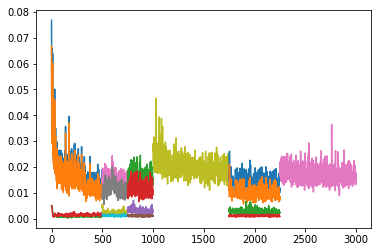

In [38]:
t = [0, 500, 750, 1000, 1750, 2250, 3000]
for i in range(len(t) - 1):
    x = np.arange(t[i], t[i+1])
    plt.plot(x, np.array(loss_history[t[i]:t[i+1]]))
plt.show()

### Model estimation

In [27]:
i = 29
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000)))

    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)

    res = sess.run([predictions, out_attention, attention_sigmoid],
                   feed_dict={trace_raw: x, is_training: False})

    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

In [28]:
out = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out_att = np.squeeze(np.concatenate([t[1] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[2] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

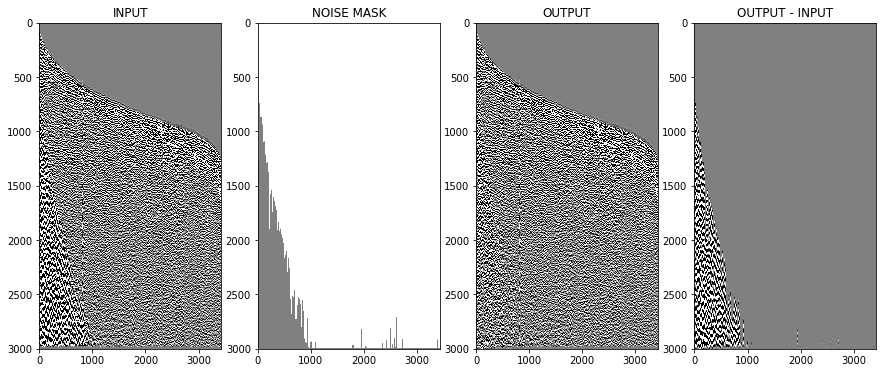

In [29]:
cv = 0.1
seismic_plot([raw, att_sigm, out, out - raw], names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

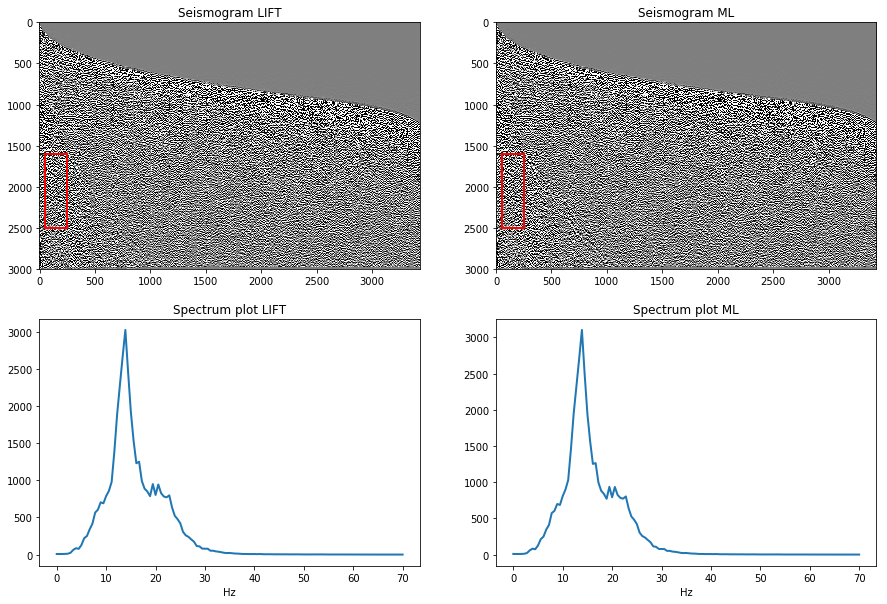

In [30]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(50, 250), slice(1600, 2500)),
                    rate=0.002, max_freq=70,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

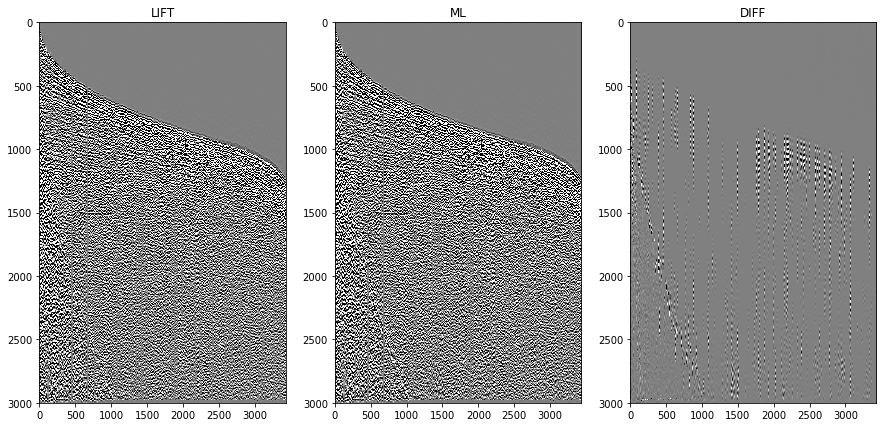

In [31]:
seismic_plot([lift, out, out - lift], names=['LIFT', 'ML', 'DIFF'],
                    figsize=(15, 7), vmin=-cv, vmax=cv, cmap='gray')

In [26]:
# saver.save(sess, '/notebooks/egor/gazprom-neft/SeismicPro/models/Ground-roll_attenuation/Attention_model/tf_attention_model.ckpt')

'/notebooks/egor/gazprom-neft/SeismicPro/models/Ground-roll_attenuation/Attention_model/tf_attention_model.ckpt'

In [32]:
np.mean(abs(lift - out)), np.mean(abs(lift[att_sigm < 0.5] - out[att_sigm < 0.5])), np.mean(abs(lift[att_sigm > 0.5] - out[att_sigm > 0.5]))

(0.0052776546, 0.006640209, 0.005133905)